In [1]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pylab as pl
from IPython import display
import sys
%matplotlib inline

In [2]:
class LSTM_cell(object):

    """
    LSTM cell object which takes 3 arguments for initialization.
    input_size = Input Vector size
    hidden_layer_size = Hidden layer size
    target_size = Output vector size

    """

    def __init__(self, input_size, hidden_layer_size, target_size):

        # Initialization of given values
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.target_size = target_size


        self.Wf = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Uf = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bf = tf.Variable(tf.zeros([self.hidden_layer_size]))        

        
        self.Wi = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Ui = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bi = tf.Variable(tf.zeros([self.hidden_layer_size]))        

        
        self.Wc = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Uc = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bc = tf.Variable(tf.zeros([self.hidden_layer_size]))
        
        self.Wog = tf.Variable(tf.zeros(
            [self.input_size, self.hidden_layer_size]))
        self.Uog = tf.Variable(tf.zeros(
            [self.hidden_layer_size, self.hidden_layer_size]))
        self.bog = tf.Variable(tf.zeros([self.hidden_layer_size]))
        
          # Weights for output layers
        self.Wo = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.target_size], mean=0, stddev=.01))
        self.bo = tf.Variable(tf.truncated_normal([self.target_size], mean=0, stddev=.01))
        
        
        self._inputs = tf.placeholder(tf.float32,
                                      shape=[None, None, self.input_size],
                                      name='inputs')

        # Processing inputs to work with scan function
        self.processed_input = process_batch_input_for_RNN(self._inputs)

        '''
        Initial hidden state's shape is [1,self.hidden_layer_size]
        In First time stamp, we are doing dot product with weights to
        get the shape of [batch_size, self.hidden_layer_size].
        For this dot product tensorflow use broadcasting. But during
        Back propagation a low level error occurs.
        So to solve the problem it was needed to initialize initial
        hiddden state of size [batch_size, self.hidden_layer_size].
        So here is a little hack !!!! Getting the same shaped
        initial hidden state of zeros.
        '''

        self.initial_hidden = self._inputs[:, 0, :]
        self.initial_hidden= tf.matmul(
            self.initial_hidden, tf.zeros([input_size, hidden_layer_size]))
        
        
        self.initial_hidden=tf.stack([self.initial_hidden,self.initial_hidden,self.initial_hidden])
    # Function for LSTM cell.
    def Lstm(self, previous_hidden_memory_tuple, x):
        """
        This function takes previous hidden state and memory tuple with input and
        outputs current hidden state.
        """
        
        previous_hidden_state,c_prev,_=tf.unstack(previous_hidden_memory_tuple)

        #Forget Gate
        f =  tf.sigmoid(
            tf.matmul(x,self.Wf)+tf.matmul(previous_hidden_state,self.Uf) + self.bf)
        
        i =  tf.sigmoid(
            tf.matmul(x,self.Wi)+tf.matmul(previous_hidden_state,self.Ui) + self.bi)
          
        c_ = tf.tanh(
            tf.matmul(x,self.Wc)+tf.matmul(previous_hidden_state,self.Uc) + self.bc)
       
        o = tf.sigmoid(tf.matmul(x,self.Wog)+tf.matmul(previous_hidden_state,self.Uog) + self.bog)
            
        #Current Hidden state
        c = f *c_prev +  c_* i
        current_hidden_state = tf.tanh(c) * o


        return tf.stack([current_hidden_state,c,f])

    # Function for getting all hidden state.
    def get_states(self):
        """
        Iterates through time/ sequence to get all hidden state
        """

        # Getting all hidden state throuh time
        all_hidden_states = tf.scan(self.Lstm,
                                    self.processed_input,
                                    initializer=self.initial_hidden,
                                    name='states')
        all_hidden_state=all_hidden_states[:,0,:,:]
        
        return all_hidden_state,all_hidden_states[:,2,:,:]

    # Function to get output from a hidden layer
    def get_output(self, hidden_state):
        """
        This function takes hidden state and returns output
        """
        output = tf.matmul(hidden_state, self.Wo) + self.bo

        return output

    # Function for getting all output layers
    def get_outputs(self):
        """
        Iterating through hidden states to get outputs for all timestamp
        """
        all_hidden_states,gates = self.get_states()

        all_outputs = tf.map_fn(self.get_output, all_hidden_states)

        return all_outputs,gates


# Function to convert batch input data to use scan ops of tensorflow.
def process_batch_input_for_RNN(batch_input):
    """
    Process tensor of size [5,3,2] to [3,5,2]
    """
    batch_input_ = tf.transpose(batch_input, perm=[2, 0, 1])
    X = tf.transpose(batch_input_)

    return X


In [3]:
hidden_layer_size = 1
input_size = 1
target_size = 1
y = tf.placeholder(tf.float32, shape=[None, target_size],name='inputs')
rnn=LSTM_cell( input_size, hidden_layer_size, target_size)
outputs,gates = rnn.get_outputs()
last_output = outputs[-1]
output=tf.nn.sigmoid(last_output)
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=last_output))
lr = tf.placeholder(dtype=tf.float32,shape=[])
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
correct_prediction = tf.equal(y,tf.round(output))
accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100
sess = tf.Session()
sess.run(tf.global_variables_initializer())
k = 2
j = 0
lear = 0.1
while(1):
    j += 1
    choose = np.random.randint(0,1401,100)
    X=np.random.binomial(n=1,p=0.5,size=(64,k,1))
    Y = np.sum(X,1) % 2
    sess.run(train_step,feed_dict={rnn._inputs:X, y:Y,lr:lear})
    X = np.random.binomial(n=1,p=0.5,size=(128,k,1))
    Y = np.sum(X,1) % 2
    Loss,acc = sess.run([cross_entropy,accuracy],feed_dict={rnn._inputs:X, y:Y})
    if Loss < 0.2 - k/100:
        print(k,acc)
        k += 1
        lear *= 0.9
    if j % 100 == 1:
        print(Loss)
    if k == 9:
        break
X_test = np.random.binomial(n=1, p=0.5, size=(2**16,100,1))
y_test = np.sum(X_test,1) % 2
Test_accuracy=str(sess.run(accuracy,feed_dict={rnn._inputs:X_test, y:y_test}))
print('Result:',Test_accuracy,'Iteration:',j)

0.69791734
2 100.0
3 100.0
4 100.0
5 100.0
6 100.0
7 100.0
8 100.0
Result: 100.0 Iteration: 75


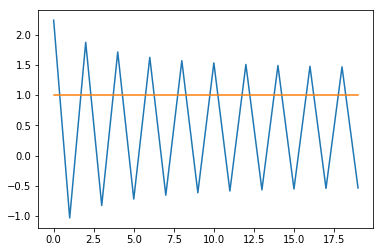

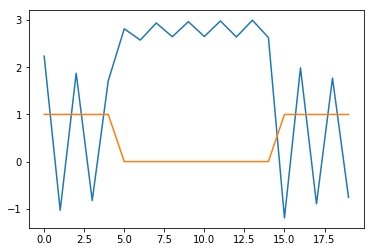

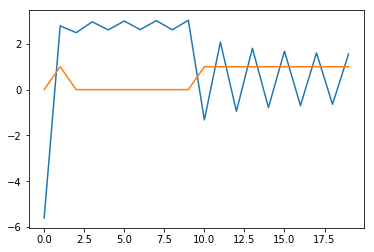

In [4]:
import matplotlib.pyplot as plt
X_test = np.random.binomial(n=1, p=1, size=(1,20,1))
hs = sess.run(outputs,feed_dict={rnn._inputs:X_test})
x_ = np.reshape(X_test,[-1,1])
plt.plot(np.reshape(hs,[-1,1]),label='H')
plt.plot(x_,label='Input')
plt.show()
X_test = np.random.binomial(n=1, p=1, size=(1,20,1))
X_test[0,5:15,0] = 0
hs = sess.run(outputs,feed_dict={rnn._inputs:X_test})
x_ = np.reshape(X_test,[-1,1])
plt.plot(np.reshape(hs,[-1,1]),label='H')
plt.plot(x_,label='Input')
plt.show()
X_test = np.random.binomial(n=1, p=0, size=(1,20,1))
X_test[0,1:2,0] = 1
X_test[0,10:20,0]= 1
x_ = np.reshape(X_test,[-1])
hs = sess.run(outputs,feed_dict={rnn._inputs:X_test})
plt.plot(np.reshape(hs,[-1,1]),label='H')
plt.plot(x_,label='Input')
plt.show()

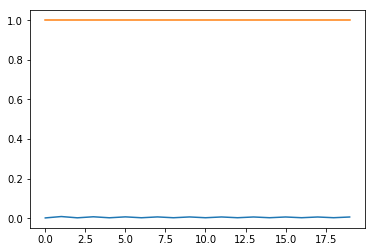

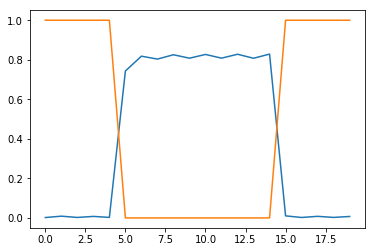

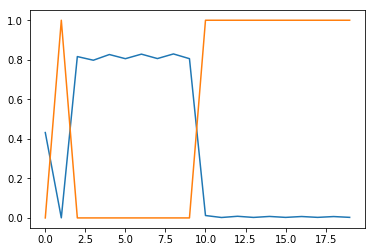

In [5]:
X_test = np.random.binomial(n=1, p=1, size=(1,20,1))
hs = sess.run(gates,feed_dict={rnn._inputs:X_test})
x_ = np.reshape(X_test,[-1,1])
plt.plot(np.reshape(hs,[-1,1]),label='H')
plt.plot(x_,label='Input')
plt.show()
X_test = np.random.binomial(n=1, p=1, size=(1,20,1))
X_test[0,5:15,0] = 0
hs = sess.run(gates,feed_dict={rnn._inputs:X_test})
x_ = np.reshape(X_test,[-1,1])
plt.plot(np.reshape(hs,[-1,1]),label='H')
plt.plot(x_,label='Input')
plt.show()
X_test = np.random.binomial(n=1, p=0, size=(1,20,1))
X_test[0,1:2,0] = 1
X_test[0,10:20,0]= 1
x_ = np.reshape(X_test,[-1])
hs = sess.run(gates,feed_dict={rnn._inputs:X_test})
plt.plot(np.reshape(hs,[-1,1]),label='H')
plt.plot(x_,label='Input')
plt.show()